# Analysing Customer Behaviour

We Will focus on 3 key features:
- **R**ecency (How many days has it been since the client made a purchase)
- **F**requency (How many total Purchases the client has made)
- **M**onetary Value (Total Monetary contribution of each client)

# Necessary imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


# Read the data:

In [3]:
df = pd.read_excel("online_retail_II.xlsx", sheet_name=0, engine='openpyxl')
# df = pd.read_excel("online_retail_II.xlsx", sheet_name=0)

In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


###### Try a high-level look of the data:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


Unusual observations:
- minimum quantity is -ve.
- Price too has -ve value
- Customer IDs are missing since it has lesser count.

### Describe() only allows us to understand the numeric only data by default.
### For describing data of 'Object' type:

In [7]:
df.describe(include='O')

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


## Observing Missing Customer Data:

### - Customer ids which are null:

In [8]:
df[df["Customer ID"].isna()].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1058,489548,22195,LARGE HEART MEASURING SPOONS,1,2009-12-01 12:32:00,1.65,NaN,United Kingdom


- These look like records that we would want to exclude since when we don't have a customer, we can't categorise and effectively work on that data. It makes impossible for us to infer which customer made the purchase.

## Observing Negative Quantities:

## - Quantities which are less than zero:

In [9]:
df[df["Quantity"]<0].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia


Here, We notice 'C' appearing as a preffix to the Invoice. According to the problem statement **C** refers to **Cancellation**.

### **Lets Analyse the INVOICE DATA**

Converting 'Invoice' to string in order to apply regex operation

In [10]:
df["Invoice"] = df["Invoice"].astype("str")
df[df["Invoice"].str.match("^\\d{6}$") == False ]


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


### Lets check if there are other prefixes to Invoice other than C:

In [11]:
df["Invoice"].str.replace("[0-9]","" , regex=True).unique()

array(['', 'C', 'A'], dtype=object)

Letter **A** also appears!

In [12]:
df[df["Invoice"].str.startswith("A")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


- Only three entries! Can be simply dropped!

## Observing Stockcodes:

In [13]:
df["StockCode"] = df["StockCode"].astype("str")
df[df["StockCode"].str.match("^\\d{5}$") == False]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
12,489436,48173C,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.95,13078.0,United Kingdom
23,489436,35004B,SET OF 3 BLACK FLYING DUCKS,12,2009-12-01 09:06:00,4.65,13078.0,United Kingdom
28,489436,84596F,SMALL MARSHMALLOWS PINK BOWL,8,2009-12-01 09:06:00,1.25,13078.0,United Kingdom
...,...,...,...,...,...,...,...,...
525387,538170,84029E,RED WOOLLY HOTTIE WHITE HEART.,2,2010-12-09 19:32:00,3.75,13969.0,United Kingdom
525388,538170,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2,2010-12-09 19:32:00,3.75,13969.0,United Kingdom
525389,538170,85232B,SET OF 3 BABUSHKA STACKING TINS,2,2010-12-09 19:32:00,4.95,13969.0,United Kingdom
525435,538171,47591D,PINK FAIRY CAKE CHILDRENS APRON,1,2010-12-09 20:01:00,1.95,17530.0,United Kingdom


- We observe Alphabets at the end of the % digit Stockcodes. Apperently they look legit entries, so we will let them be.

But Lets look if there are entries in Stockcode other than the 5 digit numbers and digits ending with an alphabet:

In [14]:
df[(df["StockCode"].str.match("^\\d{5}$") == False) & (df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]["StockCode"].unique()

array(['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004',
       'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001',
       'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044', 'TEST002',
       'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30',
       'PADS', 'ADJUST', 'gift_0001_40', 'gift_0001_60', 'gift_0001_70',
       'gift_0001_90', 'DCGSSGIRL', 'DCGS0006', 'DCGS0016', 'DCGS0027',
       'DCGS0036', 'DCGS0039', 'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT',
       'DCGSLBOY', 'm', 'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY',
       'DCGSLGIRL', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B',
       'DCGS0041', 'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE'],
      dtype=object)

### We Do get some Unique value of StockCodes. Lets Analyse each stock code and determine if considering that stockcode worth?

In [15]:
unique_stockcodes = ['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004',
                     'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001',
                     'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044',
                     'TEST002', 'gift_0001_10', 'gift_0001_50', 'DCGS0066N',
                     'gift_0001_30', 'PADS', 'ADJUST', 'gift_0001_40',
                     'gift_0001_60', 'gift_0001_70', 'gift_0001_90', 'DCGSSGIRL',
                     'DCGS0006', 'DCGS0016', 'DCGS0027', 'DCGS0036', 'DCGS0039',
                     'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT', 'DCGSLBOY', 'm',
                     'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY', 'DCGSLGIRL',
                     'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B', 'DCGS0041',
                     'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE']

for stockcode in unique_stockcodes:
    filtered_df = df[df["StockCode"].str.contains(f"^{stockcode}")]
    print(f"Results for StockCode pattern: {stockcode}")
    print(filtered_df)
    print("\n")


Results for StockCode pattern: POST
        Invoice StockCode Description  Quantity         InvoiceDate   Price  \
89       489439      POST     POSTAGE         3 2009-12-01 09:28:00   18.00   
126      489444      POST     POSTAGE         1 2009-12-01 09:55:00  141.00   
173      489447      POST     POSTAGE         1 2009-12-01 10:10:00  130.00   
625      489526      POST     POSTAGE         6 2009-12-01 11:50:00   18.00   
927     C489538      POST     POSTAGE        -1 2009-12-01 12:18:00    9.58   
...         ...       ...         ...       ...                 ...     ...   
522916   537967      POST     POSTAGE         1 2010-12-09 11:31:00   18.00   
522930   537995      POST     POSTAGE         2 2010-12-09 11:39:00   18.00   
522974   538003      POST     POSTAGE         8 2010-12-09 12:05:00   18.00   
523064   538008      POST     POSTAGE         5 2010-12-09 12:17:00   18.00   
524491   538093      POST     POSTAGE         5 2010-12-09 14:49:00   18.00   

        Custome

#### After analysing all the unique StockCodes , we conclude that the only StockCode out of all these codes , that should be considered is - **PADS** !

# Now, Lets clean the data!

In [16]:
cleaned_df = df.copy()

## 1. Clean the Invoice Column

In [17]:
cleaned_df["Invoice"] = cleaned_df["Invoice"].astype("str")
mask = ( cleaned_df["Invoice"].str.match("^\\d{6}$") == True )
cleaned_df = cleaned_df[mask]
cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


## Clean the StockCode Column

In [18]:
cleaned_df["StockCode"] = cleaned_df["StockCode"].astype("str")
mask = (
    (cleaned_df["StockCode"].str.match("^\\d{5}$") == True)
    | (cleaned_df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == True)
    | (cleaned_df["StockCode"].str.match("^PADS$") == True)
)
cleaned_df = cleaned_df[mask]
cleaned_df


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


## 3. Dropping Customer ID Column

In [19]:
cleaned_df.dropna(subset=["Customer ID"], inplace=True)

<ipython-input-19-9cbaa39cd5e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.dropna(subset=["Customer ID"], inplace=True)


---

In [20]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406337.000000,406337,406337.000000,406337.000000
mean,13.619099,2010-07-01 10:11:06.543288320,2.991462,15373.632992
min,1.000000,2009-12-01 07:45:00,0.000000,12346.000000
25%,2.000000,2010-03-26 14:01:00,1.250000,14004.000000
50%,5.000000,2010-07-09 15:48:00,1.950000,15326.000000
75%,12.000000,2010-10-14 17:09:00,3.750000,16814.000000
max,19152.000000,2010-12-09 20:01:00,295.000000,18287.000000
std,97.000659,NaN,4.285876,1677.365907


- mWe Observe that minimum price of an item goes till 0.00.  It could possibly be free items / Items as a gift with other priced items. I dont want to include such items in my analysis.

In [21]:
len(cleaned_df[cleaned_df["Price"] == 0])

28

In [22]:
cleaned_df = cleaned_df[cleaned_df["Price"] > 0.0]

In [23]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406309.000000,406309,406309.000000,406309.000000
mean,13.617924,2010-07-01 10:14:25.869572352,2.991668,15373.722268
min,1.000000,2009-12-01 07:45:00,0.001000,12346.000000
25%,2.000000,2010-03-26 14:01:00,1.250000,14006.000000
50%,5.000000,2010-07-09 15:48:00,1.950000,15326.000000
75%,12.000000,2010-10-14 17:09:00,3.750000,16814.000000
max,19152.000000,2010-12-09 20:01:00,295.000000,18287.000000
std,96.998833,NaN,4.285951,1677.329470


In [24]:
cleaned_df["Price"].min()

0.001

0.01 is a really wierd, but its okay.

# How much data did i cut off during the cleaning process?

In [25]:
len(cleaned_df)/len(df)

0.7732429238325965

## It turns out that I dropped about 23% of records during cleaning


----

# Feature Engineering
### We wish to find information rgarding - recency,frequency and monetary value

In [26]:
cleaned_df["SalesLineTotal"] = cleaned_df["Quantity"] * cleaned_df["Price"]

<ipython-input-26-b29a1774789e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df["SalesLineTotal"] = cleaned_df["Quantity"] * cleaned_df["Price"]


## Lets now aggregate the MonetaryValue, Frequency and Recency with respect to each customer:

In [27]:
aggregated_df = cleaned_df.groupby(by="Customer ID", as_index=False).agg(MonetaryValue=("SalesLineTotal", "sum"),Frequency=("Invoice", "nunique"),LastInvoiceDate=("InvoiceDate", "max"))
aggregated_df.head(5)

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate
0,12346.0,169.36,2,2010-06-28 13:53:00
1,12347.0,1323.32,2,2010-12-07 14:57:00
2,12348.0,221.16,1,2010-09-27 14:59:00
3,12349.0,2221.14,2,2010-10-28 08:23:00
4,12351.0,300.93,1,2010-11-29 15:23:00


## We compare LastInvoiceDate with Last transaction date recorded in the dataset:

In [28]:
max_invoice_date = aggregated_df["LastInvoiceDate"].max()
aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastInvoiceDate"]).dt.days
aggregated_df.head(5)

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
0,12346.0,169.36,2,2010-06-28 13:53:00,164
1,12347.0,1323.32,2,2010-12-07 14:57:00,2
2,12348.0,221.16,1,2010-09-27 14:59:00,73
3,12349.0,2221.14,2,2010-10-28 08:23:00,42
4,12351.0,300.93,1,2010-11-29 15:23:00,10


---

# Now that we have created the aggregated table, let us observe the destribution of the features

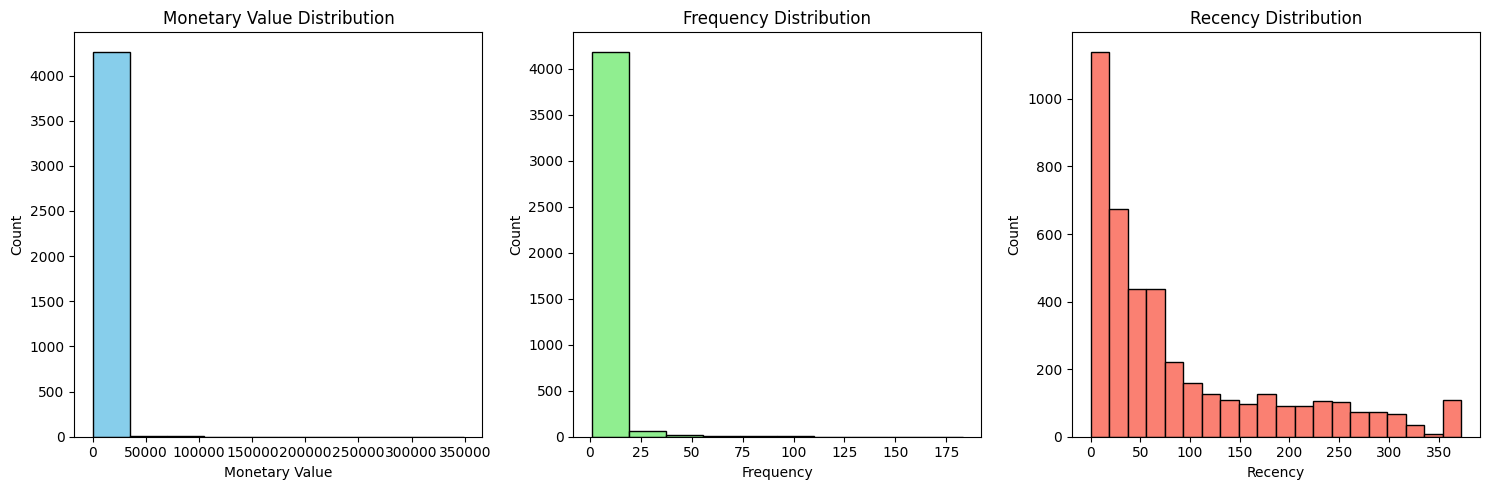

In [29]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(aggregated_df['MonetaryValue'], bins=10, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(aggregated_df['Frequency'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(aggregated_df['Recency'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


- Our distributions for MonetaryValue and Frequency looks really skewed!

### Let us use **Box plot** for **outlier Detection**

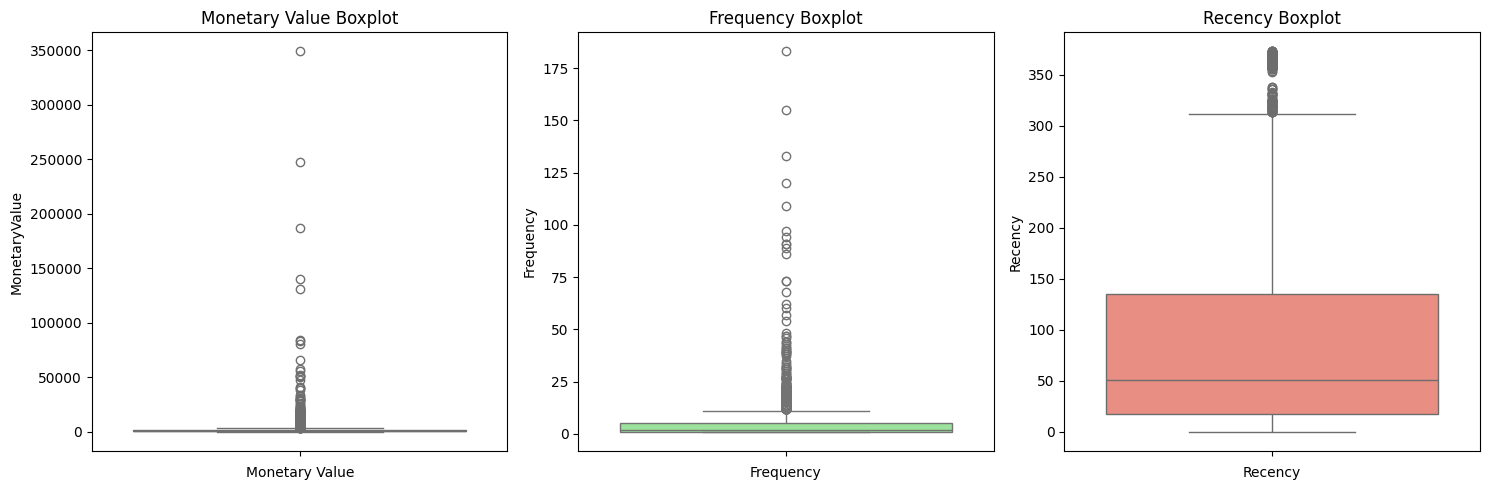

In [30]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=aggregated_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()


- Box plots for MonetaryValue and Frequency are squished.
- There are large number of outliers we would neet to deal with
**But Note that these are import Outliers, and can not be just deleted, as they represent the customers who Buy a lot and very frequent.**

#### But Let's try to seperate out outliners

In [31]:
M_Q1 = aggregated_df["MonetaryValue"].quantile(0.25)
M_Q3 = aggregated_df["MonetaryValue"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers_df = aggregated_df[(aggregated_df["MonetaryValue"] > (M_Q3 + 1.5 * M_IQR)) | (aggregated_df["MonetaryValue"] < (M_Q1 - 1.5 * M_IQR))].copy()

monetary_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,423.000000,423.000000,423.000000,423,423.000000
mean,15103.040189,12188.101740,17.167849,2010-11-09 12:26:02.978723328,30.035461
min,12357.000000,3802.040000,1.000000,2009-12-10 18:03:00,0.000000
25%,13622.000000,4605.940000,8.000000,2010-11-08 13:17:30,3.000000
50%,14961.000000,6191.320000,12.000000,2010-11-26 12:19:00,13.000000
75%,16692.000000,10273.235000,18.000000,2010-12-06 10:34:30,31.000000
max,18260.000000,349164.350000,183.000000,2010-12-09 19:32:00,364.000000
std,1728.661406,25830.851045,19.729755,NaN,51.541004


In [32]:
F_Q1 = aggregated_df['Frequency'].quantile(0.25)
F_Q3 = aggregated_df['Frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1

frequency_outliers_df = aggregated_df[(aggregated_df['Frequency'] > (F_Q3 + 1.5 * F_IQR)) | (aggregated_df['Frequency'] < (F_Q1 - 1.5 * F_IQR))].copy()

frequency_outliers_df.describe()


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,279.000000,279.000000,279.000000,279,279.000000
mean,15352.655914,14409.714932,23.810036,2010-11-23 11:06:20.645161216,16.089606
min,12437.000000,1094.390000,12.000000,2010-05-12 16:51:00,0.000000
25%,13800.000000,4331.560500,13.000000,2010-11-20 13:14:30,2.000000
50%,15465.000000,6615.770000,17.000000,2010-12-02 10:46:00,7.000000
75%,16828.500000,11692.405000,23.000000,2010-12-07 11:08:30,19.000000
max,18260.000000,349164.350000,183.000000,2010-12-09 19:32:00,211.000000
std,1748.429987,31381.736785,21.932937,NaN,26.589117


## Data Without Outliers:

In [34]:
non_outliers_df = aggregated_df[(~aggregated_df.index.isin(monetary_outliers_df.index)) & (~aggregated_df.index.isin(frequency_outliers_df.index))]

non_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,3809.000000,3809.000000,3809.000000,3809,3809.000000
mean,15376.482804,885.502197,2.863481,2010-09-03 11:16:46.516146176,97.082174
min,12346.000000,1.550000,1.000000,2009-12-01 10:49:00,0.000000
25%,13912.000000,279.910000,1.000000,2010-07-08 14:48:00,22.000000
50%,15389.000000,588.050000,2.000000,2010-10-12 16:25:00,58.000000
75%,16854.000000,1269.050000,4.000000,2010-11-17 13:14:00,154.000000
max,18287.000000,3788.210000,11.000000,2010-12-09 20:01:00,373.000000
std,1693.199806,817.672283,2.243748,NaN,98.111495


## Let us re-plot the Box Plot with non-outliers dataframe

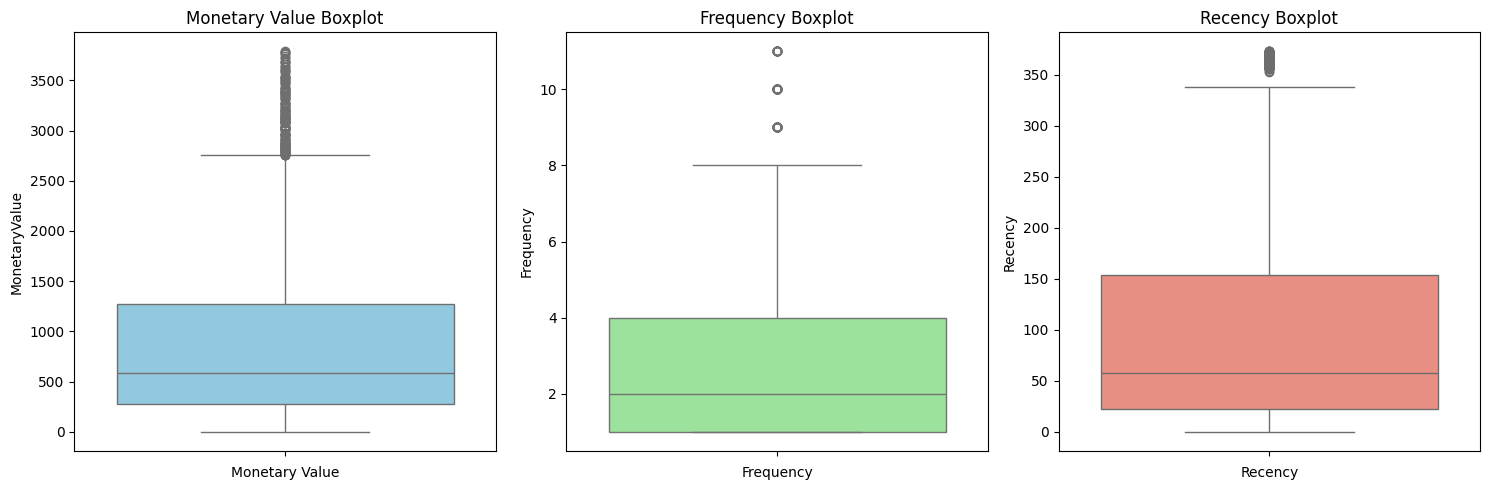

In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

- much better
- We still have outliers present but this is more tolerable.

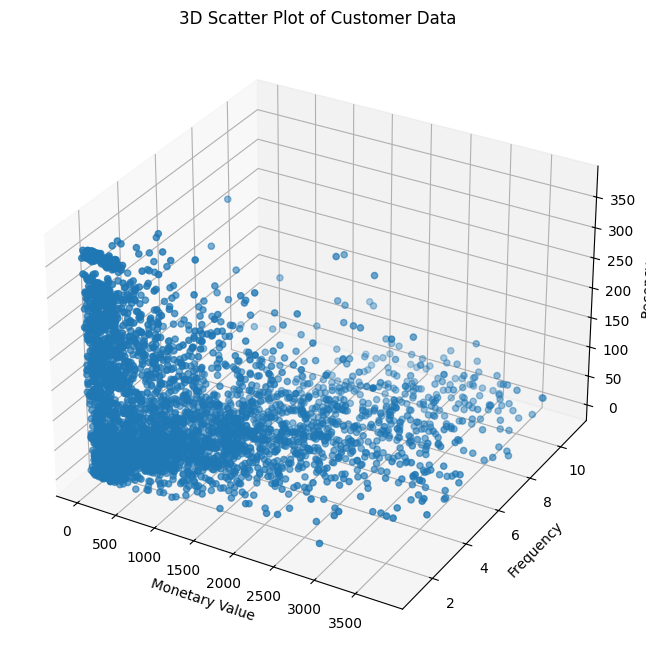

In [36]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df["MonetaryValue"], non_outliers_df["Frequency"], non_outliers_df["Recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

- Note that all 3 axes have different sale value.
- if we were to scale all of them in same scale, out data would get squashed to a single area. We dont want that.
- We want each feature to get equal weight and equal clustering.
- Thus, we scale the data

In [37]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(non_outliers_df[["MonetaryValue", "Frequency", "Recency"]])

scaled_data

array([[-0.87594534, -0.38488934,  0.68214853],
       [ 0.5355144 , -0.38488934, -0.96925093],
       [-0.81258645, -0.83063076, -0.24548944],
       ...,
       [-0.62197163, -0.83063076,  2.01753946],
       [ 0.44146683, -0.38488934,  0.14187587],
       [ 1.72488781,  0.50659348, -0.81634357]])

In [39]:
scaled_data_df = pd.DataFrame(scaled_data, index=non_outliers_df.index, columns=("MonetaryValue", "Frequency", "Recency"))

scaled_data_df

,MonetaryValue,Frequency,Recency
0,-0.875945,-0.384889,0.682149
1,0.535514,-0.384889,-0.969251
2,-0.812586,-0.830631,-0.245489
3,1.633678,-0.384889,-0.561498
4,-0.715016,-0.830631,-0.887700
...,...,...,...
4280,-0.298120,1.398076,-0.816344
4281,-0.579553,-0.830631,-0.316846
4282,-0.621972,-0.830631,2.017539
4283,0.441467,-0.384889,0.141876


### Plot the scaled data values:

Text(0.5, 0.92, '3D Scatter Plot of Customer Data')

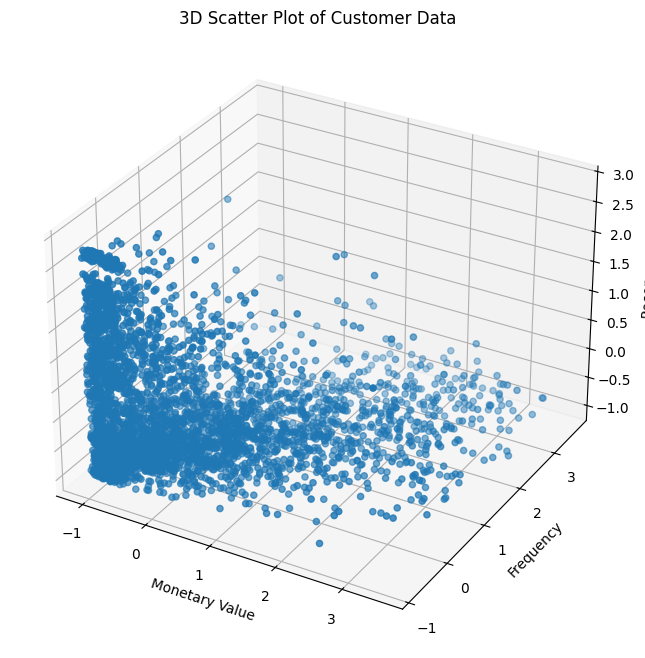

In [40]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data_df["MonetaryValue"], scaled_data_df["Frequency"], scaled_data_df["Recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

---

# K means Clustering

#### 'K' in K-means can be determined by the **elbow method**

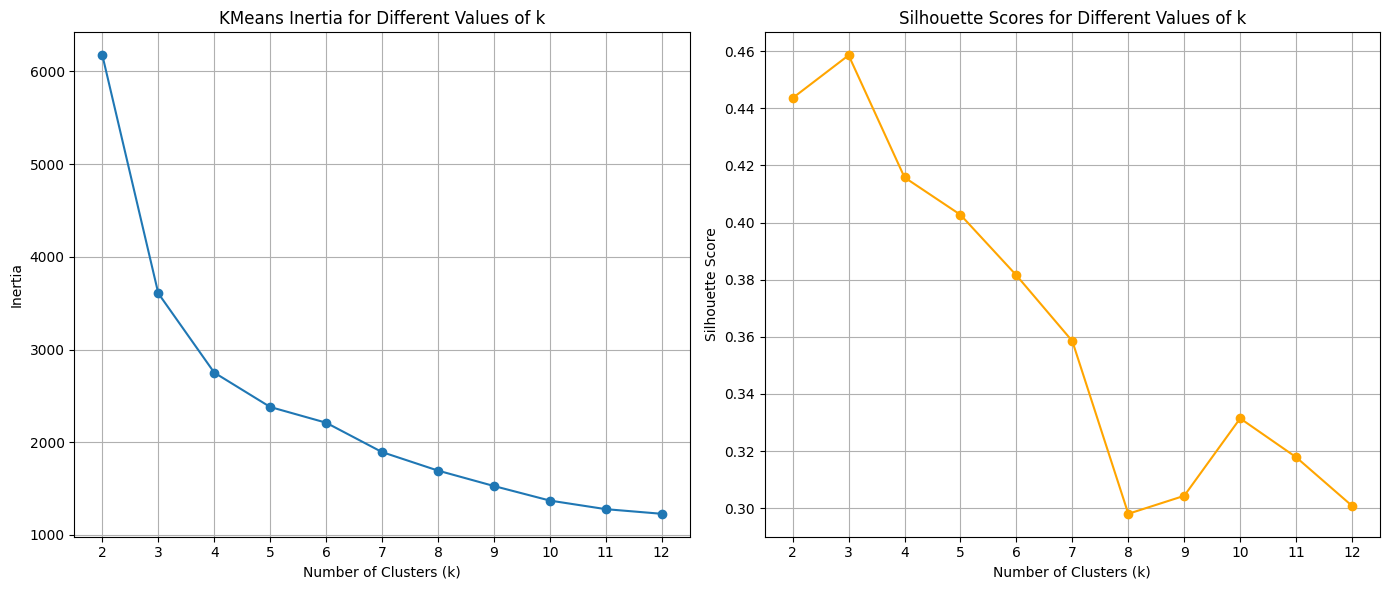

In [41]:
max_k = 12

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)

    cluster_labels = kmeans.fit_predict(scaled_data_df)

    sil_score = silhouette_score(scaled_data_df, cluster_labels)

    silhoutte_scores.append(sil_score)

    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()



The silhoutte score ranges between [-1,1]
, a higher value indicates more distinct clusters.



According to Silhoutte scores and Elbow graph, K = 4 seems appropriate

In [49]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)

cluster_labels = kmeans.fit_predict(scaled_data_df)

cluster_labels

array([1, 0, 2, ..., 1, 0, 0], dtype=int32)

In [50]:
non_outliers_df["Cluster"] = cluster_labels

non_outliers_df

<ipython-input-50-c531f568f2b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_df["Cluster"] = cluster_labels


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
0,12346.0,169.36,2,2010-06-28 13:53:00,164,1
1,12347.0,1323.32,2,2010-12-07 14:57:00,2,0
2,12348.0,221.16,1,2010-09-27 14:59:00,73,2
3,12349.0,2221.14,2,2010-10-28 08:23:00,42,0
4,12351.0,300.93,1,2010-11-29 15:23:00,10,2
...,...,...,...,...,...,...
4280,18283.0,641.77,6,2010-11-22 15:30:00,17,0
4281,18284.0,411.68,1,2010-10-04 11:33:00,66,2
4282,18285.0,377.00,1,2010-02-17 10:24:00,295,1
4283,18286.0,1246.43,2,2010-08-20 11:57:00,111,0


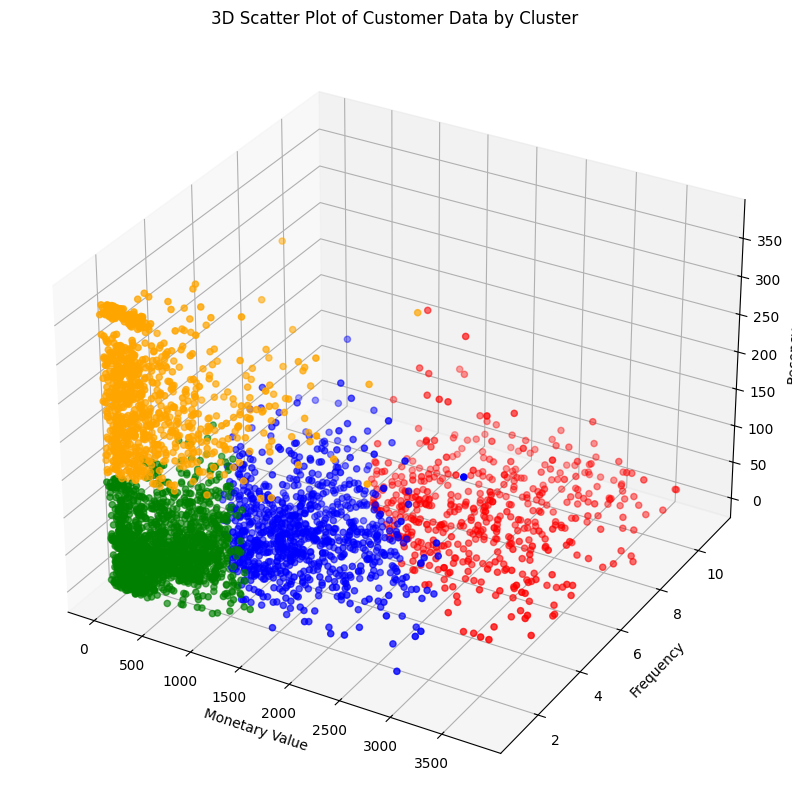

In [51]:
cluster_colors = {0: 'Blue',
                  1: 'Orange',
                  2: 'Green',
                  3: 'Red'}


colors = non_outliers_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['MonetaryValue'],
                     non_outliers_df['Frequency'],
                     non_outliers_df['Recency'],
                     c=colors,  # Use mapped solid colors
                     marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()


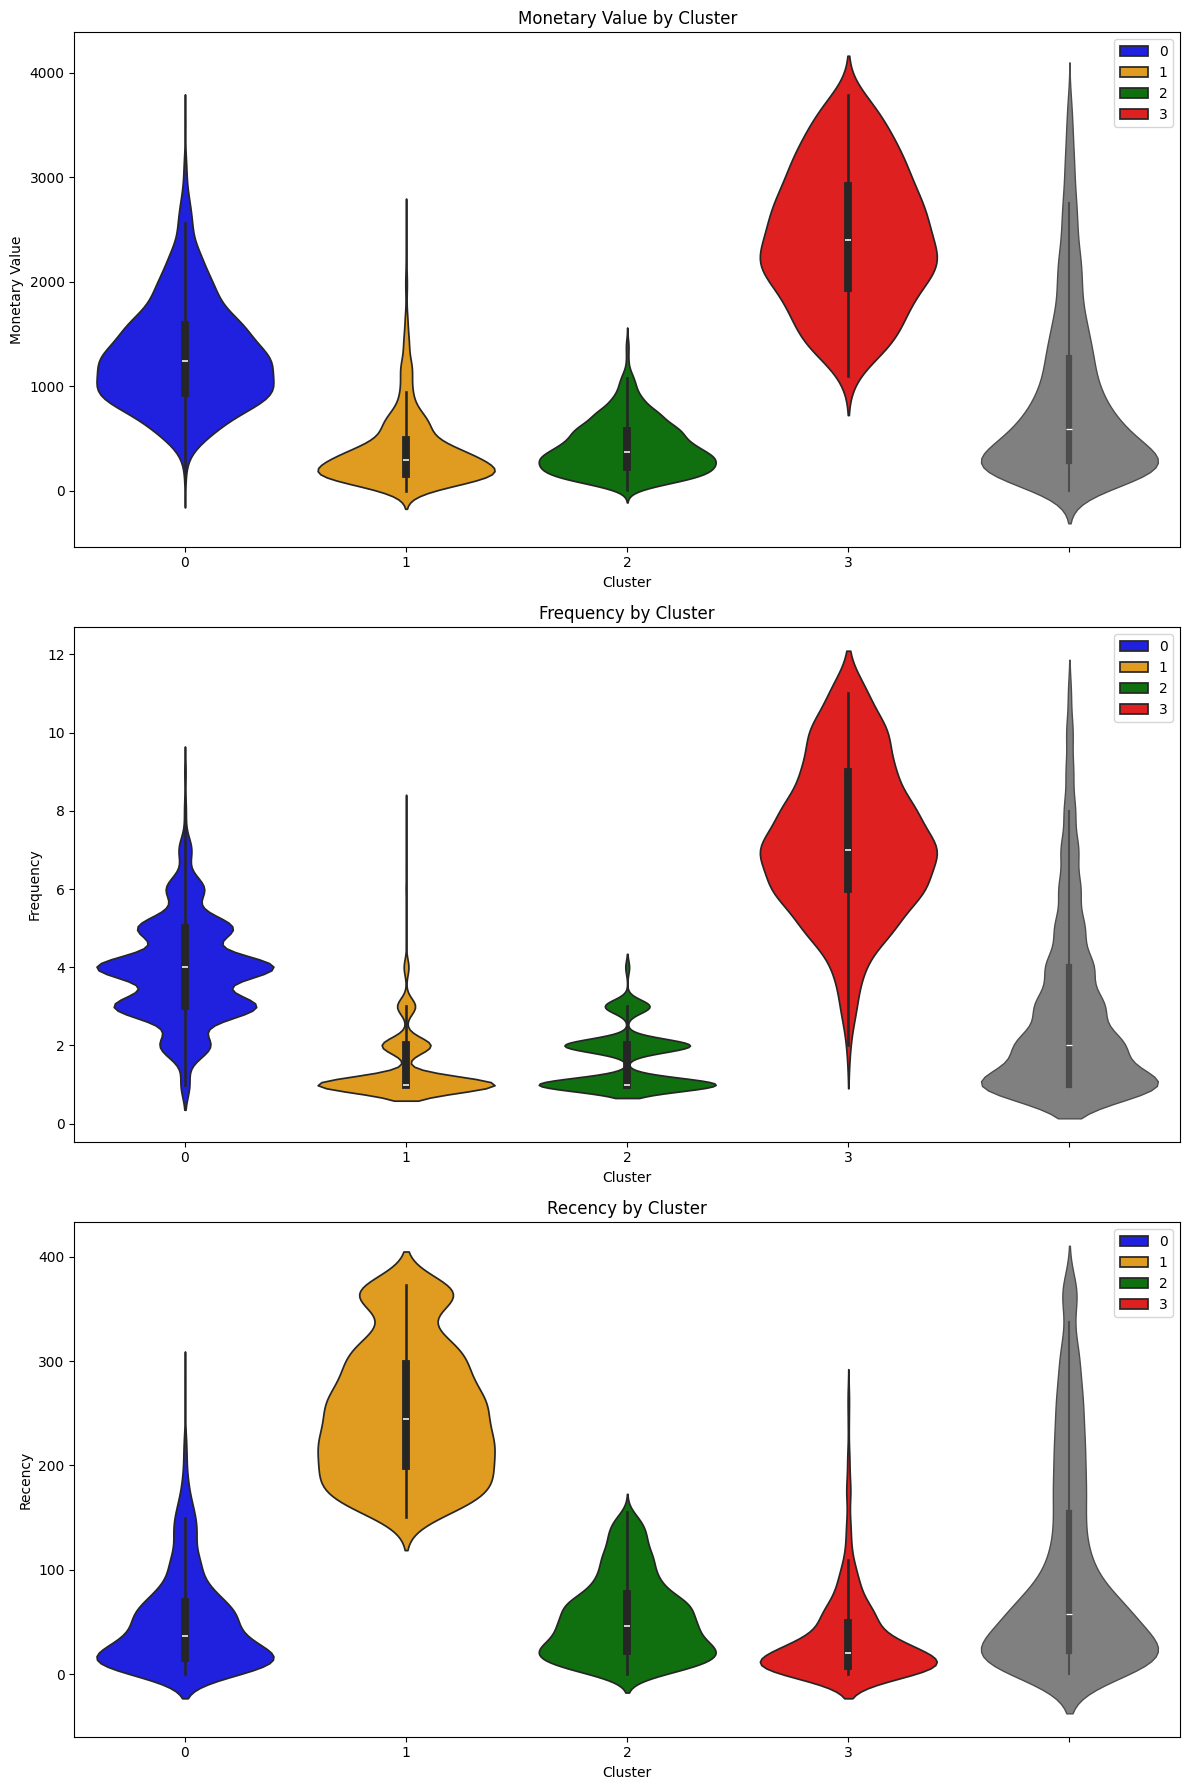

In [54]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['MonetaryValue'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')


plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Frequency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')


plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Recency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()


- Cluster 0 (Blue): "Retain":   

Rationale: This cluster represents high-value customers who purchase regularly, though not always very recently. The focus should be on retention efforts to maintain their loyalty and spending levels.

Action: Implement loyalty programs, personalized offers, and regular engagement to ensure they remain active.
- Cluster 1 (Orange): "Re-Engage"


Rationale: This group includes lower-value, infrequent buyers who haven’t purchased recently. The focus should be on re-engagement to bring them back into active purchasing behavior.

Action: Use targeted marketing campaigns, special discounts, or reminders to encourage them to return and purchase again.
- Cluster 2 (Green): "Nurture"

Rationale: This cluster represents the least active and lowest-value customers, but they have made recent purchases. These customers may be new or need nurturing to increase their engagement and spending.

Action: Focus on building relationships, providing excellent customer service, and offering incentives to encourage more frequent purchases.
- Cluster 3 (Red): "Reward"

Rationale: This cluster includes high-value, very frequent buyers, many of whom are still actively purchasing. They are your most loyal customers, and rewarding their loyalty is key to maintaining their engagement.

Action: Implement a robust loyalty program, provide exclusive offers, and recognize their loyalty to keep them engaged and satisfied.
Summary of Cluster Names:

- Cluster 0 (Blue): "Retain"
- Cluster 1 (Orange): "Re-Engage"
- Cluster 2 (Green): "Nurture"
- Cluster 3 (Red): "Reward"

In [55]:
overlap_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)

monetary_only_outliers = monetary_outliers_df.drop(overlap_indices)
frequency_only_outliers = frequency_outliers_df.drop(overlap_indices)
monetary_and_frequency_outliers = monetary_outliers_df.loc[overlap_indices]

monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3

outlier_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])

outlier_clusters_df


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
9,12357.0,11229.99,1,2010-11-16 10:05:00,23,-1
25,12380.0,4782.84,4,2010-08-31 14:54:00,100,-1
42,12409.0,12346.62,4,2010-10-15 10:24:00,55,-1
48,12415.0,19468.84,4,2010-11-29 15:07:00,10,-1
61,12431.0,4145.52,11,2010-12-01 10:03:00,8,-1
...,...,...,...,...,...,...
4235,18223.0,7516.31,12,2010-11-17 12:20:00,22,-3
4236,18225.0,7545.14,15,2010-12-09 15:46:00,0,-3
4237,18226.0,6650.83,15,2010-11-26 15:51:00,13,-3
4241,18231.0,4791.80,23,2010-10-29 14:17:00,41,-3


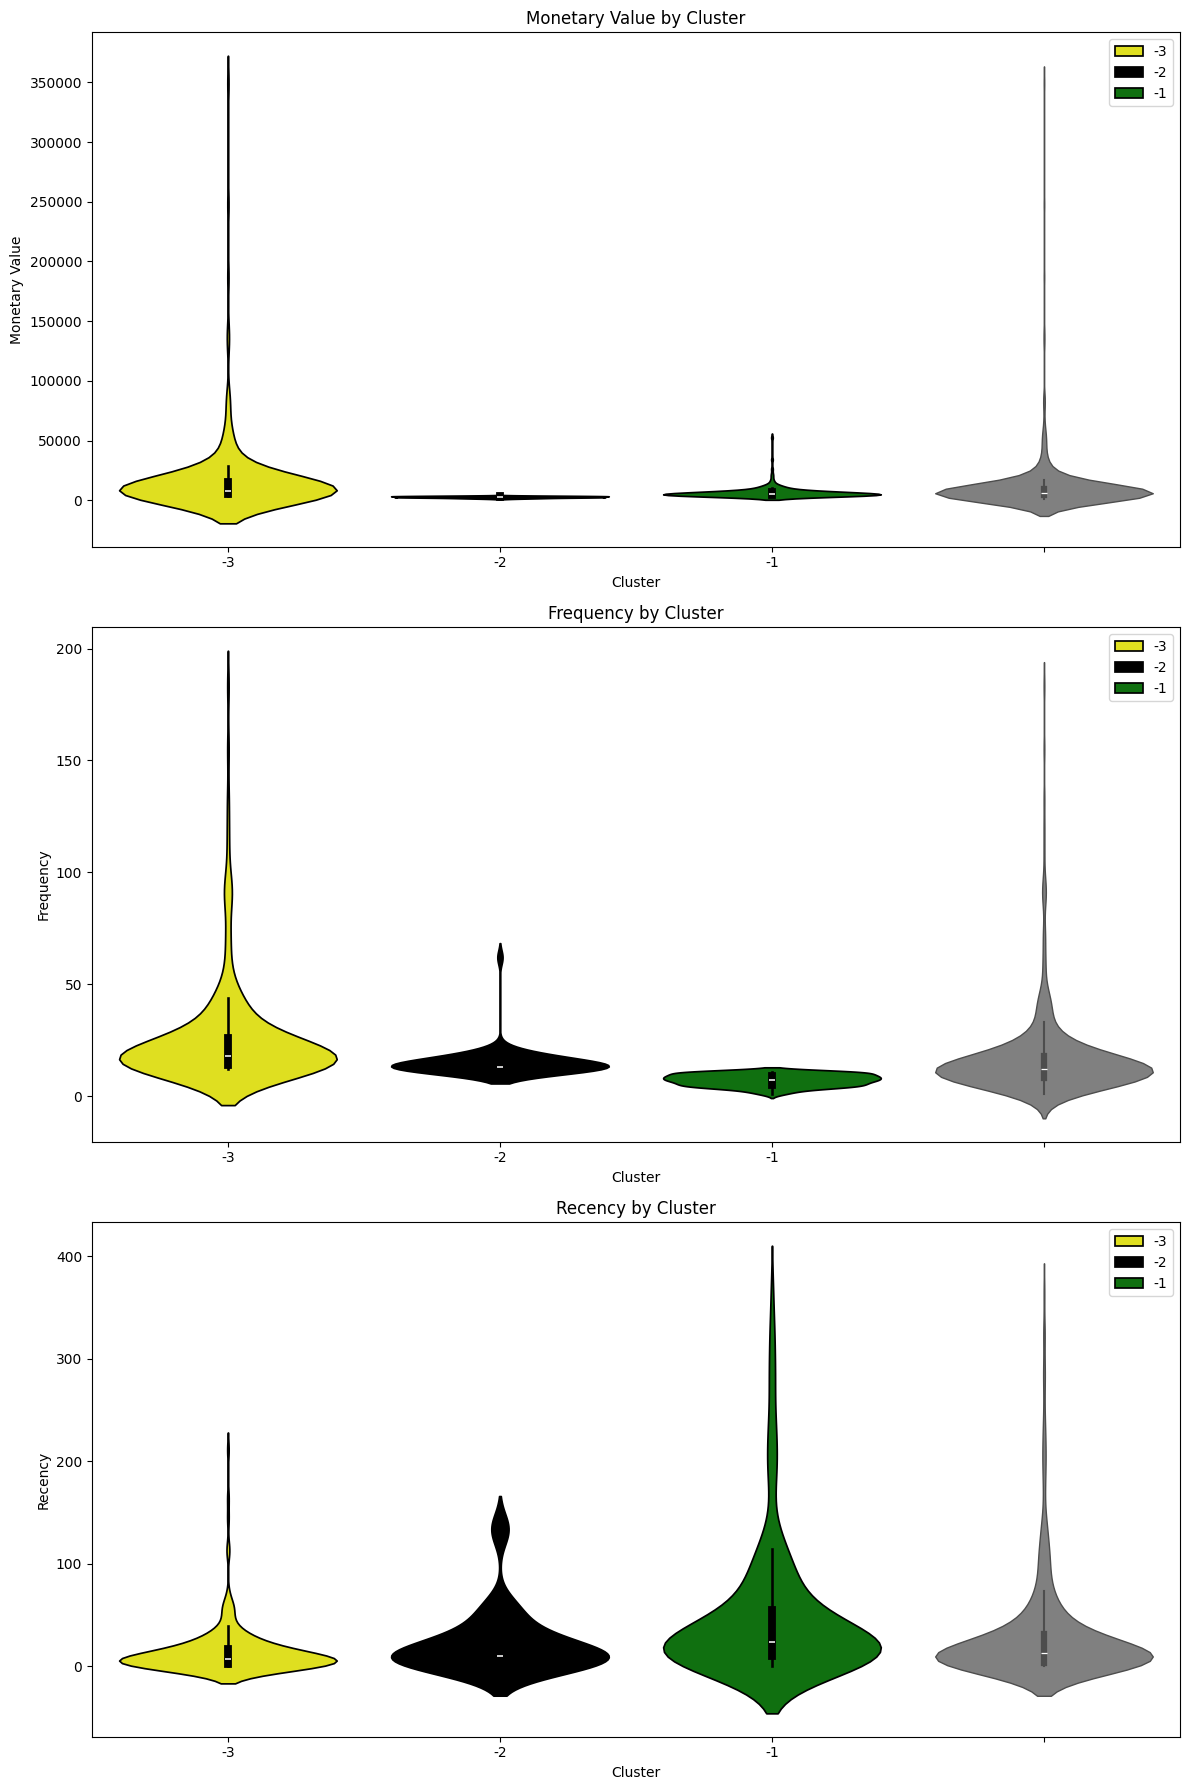

In [58]:
cluster_colors = {-1: 'green',
                  -2: 'black',
                  -3: 'yellow'}

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['MonetaryValue'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Frequency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Recency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()


 - Cluster -1 (Monetary Outliers) PAMPER:

 Characteristics: High spenders but not necessarily frequent buyers. Their purchases are large but infrequent. Potential Strategy: Focus on maintaining their loyalty with personalized offers or luxury services that cater to their high spending capacity.

- Cluster -2 (Frequency Outliers) UPSELL:

Characteristics: Frequent buyers who spend less per purchase. These customers are consistently engaged but might benefit from upselling opportunities. Potential Strategy: Implement loyalty programs or bundle deals to encourage higher spending per visit, given their frequent engagement.

- Cluster -3 (Monetary & Frequency Outliers) DELIGHT:

Characteristics: The most valuable outliers, with extreme spending and frequent purchases. They are likely your top-tier customers who require special attention. Potential Strategy: Develop VIP programs or exclusive offers to maintain their loyalty and encourage continued engagement.



Map all our clusters:

In [59]:
cluster_labels = {
    0: "RETAIN",
    1: "RE-ENGAGE",
    2: "NURTURE",
    3: "REWARD",
    -1: "PAMPER",
    -2: "UPSELL",
    -3: "DELIGHT"
}

Combining the data with and without outliers:

In [60]:
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])

full_clustering_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
0,12346.0,169.36,2,2010-06-28 13:53:00,164,1
1,12347.0,1323.32,2,2010-12-07 14:57:00,2,0
2,12348.0,221.16,1,2010-09-27 14:59:00,73,2
3,12349.0,2221.14,2,2010-10-28 08:23:00,42,0
4,12351.0,300.93,1,2010-11-29 15:23:00,10,2
...,...,...,...,...,...,...
4235,18223.0,7516.31,12,2010-11-17 12:20:00,22,-3
4236,18225.0,7545.14,15,2010-12-09 15:46:00,0,-3
4237,18226.0,6650.83,15,2010-11-26 15:51:00,13,-3
4241,18231.0,4791.80,23,2010-10-29 14:17:00,41,-3


In [61]:
full_clustering_df["ClusterLabel"] = full_clustering_df["Cluster"].map(cluster_labels)

full_clustering_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster,ClusterLabel
0,12346.0,169.36,2,2010-06-28 13:53:00,164,1,RE-ENGAGE
1,12347.0,1323.32,2,2010-12-07 14:57:00,2,0,RETAIN
2,12348.0,221.16,1,2010-09-27 14:59:00,73,2,NURTURE
3,12349.0,2221.14,2,2010-10-28 08:23:00,42,0,RETAIN
4,12351.0,300.93,1,2010-11-29 15:23:00,10,2,NURTURE
...,...,...,...,...,...,...,...
4235,18223.0,7516.31,12,2010-11-17 12:20:00,22,-3,DELIGHT
4236,18225.0,7545.14,15,2010-12-09 15:46:00,0,-3,DELIGHT
4237,18226.0,6650.83,15,2010-11-26 15:51:00,13,-3,DELIGHT
4241,18231.0,4791.80,23,2010-10-29 14:17:00,41,-3,DELIGHT


# Visualisation

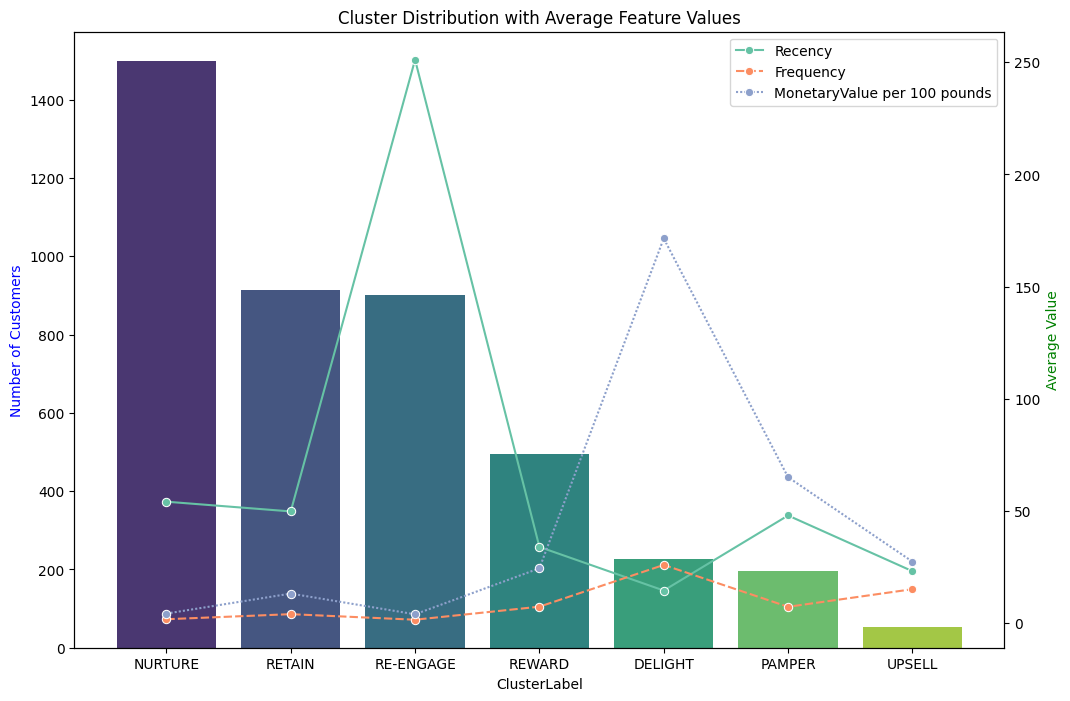

In [62]:

cluster_counts = full_clustering_df['ClusterLabel'].value_counts()
full_clustering_df["MonetaryValue per 100 pounds"] = full_clustering_df["MonetaryValue"] / 100.00
feature_means = full_clustering_df.groupby('ClusterLabel')[['Recency', 'Frequency', 'MonetaryValue per 100 pounds']].mean()

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Cluster Distribution with Average Feature Values')

ax2 = ax1.twinx()

sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value', color='g')

plt.show()